In [2]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Sequence
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from pytorch_lightning.utilities.model_summary import ModelSummary
import lightning
from lightning.fabric import Fabric
from dataclasses import dataclass
import einx

c:\Users\rahar\anaconda3\envs\neuro\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [3]:
TRAINING_PATH = "training_data/labels.txt"
DEVICE = "cuda"
torch.set_float32_matmul_precision('medium')

In [4]:
lines = []

with open(TRAINING_PATH) as f:
	for i in f:
		lines.append(i)

n_sequences = len(lines)//3

In [5]:
sequences = []

for i in range(n_sequences):
	seq_id,seq_len = (lines[i*3]).split(" | ")
	assert seq_id[0] == ">"
	seq_id = seq_id[1:]
	seq_len = int(seq_len)
	seq = lines[i*3+1].strip()
	labels = lines[i*3+2].strip()

	sequences.append([seq_id,seq,labels])


In [6]:
d = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

amino_acids = list(d.values())

amino_to_int_dict = {i:idx+3 for idx,i in enumerate(amino_acids)}
amino_to_int_dict["<PAD>"] = 0
amino_to_int_dict["<MASK>"] = 1
amino_to_int_dict["<END>"] = 0
int_to_amino_dict = {v:k for v,k in amino_to_int_dict.items()}

secondary_to_int_dict = {"<PAD>":2,"-":0,"H":1,"<END>":0}
int_to_secondary_dict = {v:k for v,k in secondary_to_int_dict.items()}

In [7]:
def tokenize_from_dict(sequence,tokenizer_dict,length=None):

	if length is None:
		length = len(sequence)

	seq = []

	for i in range(length):

		if i>len(sequence):
			seq.append(tokenizer_dict["<PAD>"])
		elif i == len(sequence):
			seq.append(tokenizer_dict["<END>"])
		else:
			seq.append(tokenizer_dict[sequence[i]])

	return torch.tensor(seq)


In [8]:
inputs = []
labels = []

l_max = 384

for seq in sequences:
	if len(seq[1])<=l_max-1:
		inputs.append(tokenize_from_dict(seq[1],amino_to_int_dict,l_max))
		labels.append(tokenize_from_dict(seq[2],secondary_to_int_dict,l_max))

In [9]:
def get_xy(sequences,l_max):

	inputs = []
	labels = []

	for seq in sequences:
		if len(seq[1])<=l_max-1:
			inputs.append(tokenize_from_dict(seq[1],amino_to_int_dict,l_max))
			labels.append(tokenize_from_dict(seq[2],secondary_to_int_dict,l_max))

	return torch.stack(inputs),torch.stack(labels)

In [10]:
inputs,labels = get_xy(sequences,384)

In [11]:
len(sequences)

5326

In [12]:
@dataclass
class ModelConfig:
	n_amino:int
	amino_dim:int
	n_heads:int
	n_layers:int
	expansion_factor:int

In [13]:
class FactorizedConv(lightning.LightningModule):

	def __init__(self,
			  in_dim,
			  feature,
			  kernel_size):
		
		super().__init__()
		
		self.conv = nn.Conv1d(in_dim,in_dim,kernel_size=kernel_size,
						groups=in_dim,padding=(kernel_size//2))
		self.dense = nn.Conv1d(in_dim,feature,1)
	
	def forward(self,x):

		x = einx.rearrange("b l d -> b d l",x)
		x = self.conv(x)
		x = self.dense(x)
		x = einx.rearrange("b d l -> b l d",x)
		return x

In [14]:
class MLP(lightning.LightningModule):

	def __init__(self,
			  in_dim:int,
			  features:list[int],
			  kernel_size:int):
		
		super().__init__()
		
		layers = []

		for feature in features:
			layers.append(FactorizedConv(in_dim,feature,kernel_size))
			in_dim = feature

		self.layers = nn.Sequential(*layers)
		self.ln = nn.LayerNorm(feature)

	def forward(self,x):

		for l in self.layers[:-1]:
			x = F.relu(l(x))
		x = self.ln(self.layers[-1](x))
		return x

In [15]:
def sin_pos_encode(x):
	embeddings = torch.zeros((x.shape)).to(x.device)
	batch,length,dim = x.shape
	position = torch.arange(0,length).to(x.device)
	omega = torch.exp(torch.arange(0,dim,2).to(x.device) * math.log(10000)/dim)
	embeddings[:,:,0::2] = torch.sin(einx.multiply("l,d -> l d",position,omega))
	embeddings[:,:,1::2] = torch.cos(einx.multiply("l,d -> l d",position,omega))

	return embeddings + x


In [16]:

class Rotary(torch.nn.Module):
    def __init__(self, dim, base=10000):
        super().__init__()
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer("inv_freq", inv_freq)
        self.seq_len_cached = None
        self.cos_cached = None
        self.sin_cached = None

    def forward(self, x, seq_dim=1):
        seq_len = x.shape[seq_dim]
        if seq_len != self.seq_len_cached:
            self.seq_len_cached = seq_len
            t = torch.arange(x.shape[seq_dim], device=x.device).type_as(self.inv_freq)
            freqs = torch.einsum("i,j->ij", t, self.inv_freq)
            emb = torch.cat((freqs, freqs), dim=-1).to(x.device)
            self.cos_cached = emb.cos()[:, None, None, :]
            self.sin_cached = emb.sin()[:, None, None, :]
        return self.cos_cached, self.sin_cached


# rotary pos emb helpers:

def rotate_half(x):
    x1, x2 = x[..., : x.shape[-1] // 2], x[..., x.shape[-1] // 2 :]
    return torch.cat(
        (-x2, x1), dim=x1.ndim - 1
    )  # dim=-1 triggers a bug in torch < 1.8.0


@torch.jit.script
def apply_rotary_pos_emb(q, k, cos, sin):
    return (q * cos) + (rotate_half(q) * sin), (k * cos) + (rotate_half(k) * sin)

In [46]:
class MaskedMHA(lightning.LightningModule):

	def __init__(self,
			  hidden_dim:int,
			  heads:int):
		
		super().__init__()
		
		self.proj = nn.Linear(hidden_dim,hidden_dim*3)
		self.heads = heads
	
	def forward(self,x,mask):

		proj = self.proj(x)

		q,k,v = einx.rearrange("b l (k d) -> k b l d",proj,k=3)

		q = q * ((q.shape[-1] // self.heads) ** -0.5)
		attn = einx.dot("b q (h c), b k (h c) -> b q k h", q, k, h=self.heads)

		attn = einx.where("b k, b q k h,", mask, attn, -torch.inf)

		attn = einx.softmax("b q [k] h", attn)
		y = einx.dot("b q k h, b k (h c) -> b q (h c)", attn, v)

		return x + y

In [157]:
class ROPEMaskedMHA(lightning.LightningModule):

	def __init__(self,
			  hidden_dim:int,
			  heads:int):
		
		super().__init__()
		
		self.proj = nn.Linear(hidden_dim,hidden_dim*3)
		self.heads = heads
		self.rope = Rotary(hidden_dim//heads)

	
	def forward(self,x,mask):

		proj = self.proj(x)

		q,k,v = einx.rearrange("b l (k h d) -> k l b h d",proj,k=3,h=self.heads)

		cos,sin = self.rope(x)

		q,k = apply_rotary_pos_emb(q,k,cos,sin)

		q = q * ((q.shape[-1]) ** -0.5)
		attn = einx.dot("l1 b h c, l2 b h c -> b l1 l2 h", q, k, h=self.heads)

		attn = einx.where("b k, b q k h,", mask, attn, -torch.inf)

		attn = einx.softmax("b q [k] h", attn)
		y = einx.dot("b q k h, k b h c -> b q (h c)", attn, v)

		return x + y

In [158]:
class EncoderBlock(lightning.LightningModule):

	def __init__(self,
			  hidden_dim:int,
			  heads:int,
			  expansion_factor:int):
		
		super().__init__()
		
		self.mha = ROPEMaskedMHA(hidden_dim,heads)
		self.mlp = MLP(hidden_dim,[hidden_dim*expansion_factor,hidden_dim],kernel_size=3)
		self.mha_ln = nn.LayerNorm(hidden_dim)
		self.mlp_ln = nn.LayerNorm(hidden_dim)
		self.drop = nn.Dropout(0.1)

	def forward(self,x,mask):

		x = x + self.drop(self.mha_ln(self.mha(x,mask))) + self.drop(self.mlp_ln(self.mlp(x)))
		return x

In [159]:
encoder = EncoderBlock(32,4,2)
x = torch.randn((16,384,32))
mask = torch.ones((16,384),dtype=bool)

In [161]:
class Transformer(lightning.LightningModule):

	def __init__(self,
			  n_amino:int,
			  amino_dim:int,
			  n_heads:int,
			  n_layers:int,
			  hidden_dim:int,
			  expansion_factor:int):
		
		super().__init__()
		
		self.embeddings = nn.Embedding(n_amino,amino_dim)
		layers = []

		for _ in range(n_layers):
			layers.append(EncoderBlock(hidden_dim,n_heads,expansion_factor))

		self.layers = nn.Sequential(*layers)
		self.masked_lm_head = nn.Linear(hidden_dim,n_amino)
		self.structure_head = nn.Linear(hidden_dim,2)

	def forward(self,x,mask):

		x = self.embeddings(x)
		x = sin_pos_encode(x)

		for h in self.layers:
			x = h(x,mask)

		return x
	
	def lm_forward(self,x,mask):

		x = self(x,mask)
		x = self.masked_lm_head(x)
		return x
	
	def structure_forward(self,x,mask):

		x = self(x,mask)
		x = self.structure_head(x)
		return x

In [162]:
class Hyena(lightning.LightningModule):

	def __init__(self,
			  hidden_dim:int,
			  kernel_size:int):
		
		super().__init__()
		
		self.k1 = nn.Conv1d(hidden_dim,hidden_dim,kernel_size,
					  groups=hidden_dim,padding=kernel_size//2)
		self.k2 = nn.Conv1d(hidden_dim,hidden_dim,kernel_size,
					  groups=hidden_dim,padding=kernel_size//2)
		
		self.proj  = nn.Linear(hidden_dim,3*hidden_dim)

	def forward(self,x,mask):

		proj = self.proj(x)
		q,k,v = einx.rearrange("b l (k d) -> k b d l",proj,k=3)
		y = F.sigmoid(self.k1(q))
		y =  v*self.k2(k*y)
		y = einx.rearrange("b d l -> b l d",y)
		return y


In [163]:
class HyenaBlock(lightning.LightningModule):

	def __init__(self,
			  hidden_dim:int,
			  kernel_size:int):

		super().__init__()

		self.hyena_operator = Hyena(hidden_dim,kernel_size)
		self.mlp = MLP(hidden_dim,[hidden_dim,hidden_dim],3)
		self.ln = nn.LayerNorm(hidden_dim)
		self.drop = nn.Dropout(0.1)

	def forward(self,x,mask):

		x = x + self.drop(self.ln(self.hyena_operator(x,mask))) + self.drop(self.ln(self.mlp(x)))
		return x

In [164]:
class HyenaFormer(lightning.LightningModule):

	def __init__(self,
			  n_amino:int,
			  amino_dim:int,
			  kernel_size:int,
			  n_layers:int):

		super().__init__()
		
		self.embeddings = nn.Embedding(n_amino,amino_dim)
		layers = []

		for _ in range(n_layers):
			layers.append(HyenaBlock(amino_dim,kernel_size))

		self.layers = nn.Sequential(*layers)
		self.masked_lm_head = nn.Linear(amino_dim,n_amino)
		self.structure_head = nn.Linear(amino_dim,2)

	def forward(self,x,mask):

		x = self.embeddings(x)

		for h in self.layers:
			x = h(x,mask)

		return x
	
	def lm_forward(self,x,mask):

		x = self(x,mask)
		x = self.masked_lm_head(x)
		return x
	
	def structure_forward(self,x,mask):

		x = self(x,mask)
		x = self.structure_head(x)
		return x

In [165]:
class StrippedHyena(lightning.LightningModule):

	def __init__(self,
			  n_amino:int,
			  amino_dim:int,
			  kernel_size:int,
			  n_layers:int):

		super().__init__()
		
		self.embeddings = nn.Embedding(n_amino,amino_dim)
		layers = []

		for _ in range(n_layers//2):
			layers.append(HyenaBlock(amino_dim,kernel_size))
			layers.append(EncoderBlock(amino_dim,4,2))

		self.layers = nn.Sequential(*layers)
		self.masked_lm_head = nn.Linear(amino_dim,n_amino)
		self.structure_head = nn.Linear(amino_dim,2)

	def forward(self,x,mask):

		x = self.embeddings(x)

		for h in self.layers:
			x = h(x,mask)

		return x
	
	def lm_forward(self,x,mask):

		x = self(x,mask)
		x = self.masked_lm_head(x)
		return x
	
	def structure_forward(self,x,mask):

		x = self(x,mask)
		x = self.structure_head(x)
		return x

In [166]:
class CNN(lightning.LightningModule):

	def __init__(self,
			n_amino:int,
			amino_dim:int,
			n_layers:int,
			kernel_size:int):
		
		super().__init__()
		
		self.embeddings = nn.Embedding(n_amino,amino_dim)
		layers = []

		for _ in range(n_layers):
			layers.append(FactorizedConv(amino_dim,amino_dim,kernel_size))
			#layers.append(nn.Conv1d(amino_dim,amino_dim,kernel_size,padding=kernel_size//2))

		self.layers = nn.Sequential(*layers)
		self.masked_lm_head = nn.Linear(amino_dim,n_amino)
		self.structure_head = nn.Linear(amino_dim,2)
		self.drop = nn.Dropout(0.1)

	def forward(self,x,mask):

		x = self.embeddings(x)

		#x = einx.rearrange("b l d -> b d l",x)
		for h in self.layers:
			x = F.relu(self.drop(h(x)))

		#x = einx.rearrange("b d l -> b l d",x)

		return x
	
	def lm_forward(self,x,mask):

		x = self(x,mask)
		x = self.masked_lm_head(x)
		return x
	
	def structure_forward(self,x,mask):

		x = self(x,mask)
		x = self.structure_head(x)
		return x


In [167]:
class LSTM(lightning.LightningModule):

	def __init__(self,
			n_amino:int,
			amino_dim:int,
			n_layers:int,):
		
		super().__init__()
		
		self.embeddings = nn.Embedding(n_amino,amino_dim)
		self.layers = nn.LSTM(amino_dim,amino_dim,n_layers,batch_first=True,
						bidirectional=True)
		self.masked_lm_head = nn.Linear(amino_dim*2,n_amino)
		self.structure_head = nn.Linear(amino_dim*2,2)

	def forward(self,x,mask):

		x = self.embeddings(x)
		out,(h,c) = self.layers(x)
		return out
	
	def lm_forward(self,x,mask):

		x = self(x,mask)
		x = self.masked_lm_head(x)
		return x
	
	def structure_forward(self,x,mask):

		x = self(x,mask)
		x = self.structure_head(x)
		return x


In [197]:
model = Transformer(
	n_amino=len(amino_to_int_dict),
	amino_dim=32,
	hidden_dim=32,
	n_heads=4,
	n_layers=6,
	expansion_factor=2
)

cnn_model = CNN(len(amino_to_int_dict),32,8,5)

lstm_model = LSTM(len(amino_to_int_dict),32,2)

hyena_model = StrippedHyena(len(amino_to_int_dict),64,31,8)


In [198]:
hyena_model

StrippedHyena(
  (embeddings): Embedding(23, 64)
  (layers): Sequential(
    (0): HyenaBlock(
      (hyena_operator): Hyena(
        (k1): Conv1d(64, 64, kernel_size=(31,), stride=(1,), padding=(15,), groups=64)
        (k2): Conv1d(64, 64, kernel_size=(31,), stride=(1,), padding=(15,), groups=64)
        (proj): Linear(in_features=64, out_features=192, bias=True)
      )
      (mlp): MLP(
        (layers): Sequential(
          (0): FactorizedConv(
            (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), groups=64)
            (dense): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
          )
          (1): FactorizedConv(
            (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), groups=64)
            (dense): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
          )
        )
        (ln): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (ln): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (drop): Dropout(p=0

In [199]:
ModelSummary(hyena_model)

  | Name           | Type       | Params
----------------------------------------------
0 | embeddings     | Embedding  | 1.5 K 
1 | layers         | Sequential | 223 K 
2 | masked_lm_head | Linear     | 1.5 K 
3 | structure_head | Linear     | 130   
----------------------------------------------
226 K     Trainable params
0         Non-trainable params
226 K     Total params
0.906     Total estimated model params size (MB)

In [200]:
ModelSummary(lstm_model)

  | Name           | Type      | Params
---------------------------------------------
0 | embeddings     | Embedding | 736   
1 | layers         | LSTM      | 42.0 K
2 | masked_lm_head | Linear    | 1.5 K 
3 | structure_head | Linear    | 130   
---------------------------------------------
44.3 K    Trainable params
0         Non-trainable params
44.3 K    Total params
0.177     Total estimated model params size (MB)

In [201]:
ModelSummary(cnn_model)

  | Name           | Type       | Params
----------------------------------------------
0 | embeddings     | Embedding  | 736   
1 | layers         | Sequential | 10.0 K
2 | masked_lm_head | Linear     | 759   
3 | structure_head | Linear     | 66    
4 | drop           | Dropout    | 0     
----------------------------------------------
11.5 K    Trainable params
0         Non-trainable params
11.5 K    Total params
0.046     Total estimated model params size (MB)

In [202]:
ModelSummary(model)

  | Name           | Type       | Params
----------------------------------------------
0 | embeddings     | Embedding  | 736   
1 | layers         | Sequential | 47.6 K
2 | masked_lm_head | Linear     | 759   
3 | structure_head | Linear     | 66    
----------------------------------------------
49.2 K    Trainable params
0         Non-trainable params
49.2 K    Total params
0.197     Total estimated model params size (MB)

In [203]:
def one_hot(x, num_classes):
    return torch.eye(num_classes).to(x.device)[x]


In [204]:

def masked_accuracy(logits, labels, mask):
    predictions = torch.argmax(logits, axis=-1)
    correct_predictions = (predictions == labels) * mask
    accuracy = torch.sum(correct_predictions) / torch.sum(mask)
    return accuracy

In [205]:
def train_val_split(x,y,p):

	permutations = torch.randperm(len(x))
	p = int(len(x)*p)

	return x[permutations[:p]],y[permutations[:p]],x[permutations[p:]],y[permutations[p:]]

In [206]:
x_test,y_test,x_train,y_train = train_val_split(inputs,labels,0.05)

In [207]:
def get_batch_idx(n:int,
				  batch_size:int,
				  shuffle:bool=True):

	if shuffle:
		permutations = torch.randperm(n)
	else:
		permutations = torch.arange(n)
	
	permutations = permutations[0:batch_size*(n//batch_size)]
	batches = einx.rearrange("(n b) -> n b",permutations,b=batch_size)

	return batches

In [208]:
def mask_from_list(x,values):

	mask = torch.zeros_like(x,dtype=torch.bool)

	for i in values:
		mask += (x == i)

	return mask

In [209]:
def torch_train(fabric,
				model:Transformer,
				mask_function,
				x_train,
				y_train,
				x_test,
				y_test,
				batch_size,
				n_epochs,):
	
	loss_fn = nn.CrossEntropyLoss(reduce=True,ignore_index=-100)
	
	def loss_acc(fabric,
			  model,
			  x_batch,
			  y_batch,
			  model_mask,
			  loss_mask):
			
		with fabric.autocast():

			x_batch = x_batch.to(DEVICE)
			y_batch = y_batch.to(DEVICE)
			model_mask = model_mask.to(DEVICE)
			loss_mask = loss_mask.to(DEVICE)
		
			y_pred = model.structure_forward(x_batch,model_mask)
			y_batch[torch.logical_not(loss_mask)] = -100
			loss = loss_fn(einx.rearrange("b l c -> b c l",y_pred),y_batch)
			acc = masked_accuracy(y_pred,y_batch,loss_mask)
		return loss,acc

	
	def val_loop(fabric,
			  model:Transformer,
			  x_test,
			  y_test,
			  batch_size,):
		
		
		batches = get_batch_idx(len(x_test),batch_size,False)

		val_losses = []
		val_acc = []

		model.eval()

		with torch.no_grad():

			for b,indices in enumerate(batches):

				x_batch = x_test[indices]
				y_batch = y_test[indices]

				pad_mask = mask_from_list(x_batch,[0,1])

				masked = mask_function(pad_mask)

				loss,acc = loss_acc(fabric,model,x_batch,y_batch,masked,masked)
				val_losses.append(loss.item())
				val_acc.append(acc.item())

		model.train()

		return np.mean(val_losses),np.mean(val_acc)
	
	optimizer = torch.optim.AdamW(model.parameters(),
							   lr=1E-3,
							   weight_decay=1E-1)
	
	model,optimizer = fabric.setup(model,optimizer)

	val_acc_results = []
	train_acc_results = []

	for epoch in range(n_epochs):

		batches = get_batch_idx(len(x_train),batch_size,True)

		losses = []
		accuracies = []

		for b,indices in enumerate(batches):

			x_batch = x_train[indices]
			y_batch = y_train[indices]

			# mask pad tokens

			pad_mask = mask_from_list(x_batch,[0,1])

			# mask (for language modeling)

			masked = mask_function(pad_mask)

			loss,acc = loss_acc(fabric,model,x_batch,y_batch,masked,masked)

			fabric.backward(loss)

			optimizer.step()
			optimizer.zero_grad()

			losses.append(loss.item())
			accuracies.append(acc.item())

		val_loss,val_acc = val_loop(fabric,model,x_test,y_test,batch_size,)

		train_acc_results.append(np.mean(accuracies))
		val_acc_results.append(val_acc)

		print(f"Training loss: {np.mean(losses)} | Training acc: {np.mean(accuracies)} | Val loss: {val_loss} | Vall acc: {val_acc}")

	return train_acc_results,val_acc_results


In [210]:
def lm_train(fabric,
				model:Transformer,
				mask_function,
				x_train,
				y_train,
				x_test,
				y_test,
				batch_size,
				n_epochs,):
	
	loss_fn = nn.CrossEntropyLoss(reduce=True,ignore_index=-100)
	
	def loss_acc(fabric,
			  model:Transformer,
			  x_batch,
			  y_batch,
			  model_mask,
			  loss_mask):
			
		with fabric.autocast():

			x_batch = x_batch.to(DEVICE)
			y_batch = y_batch.to(DEVICE)
			model_mask = model_mask.to(DEVICE)
			loss_mask = loss_mask.to(DEVICE)
		
			y_pred = model.lm_forward(x_batch,model_mask)
			y_batch[torch.logical_not(loss_mask)] = -100
			loss = loss_fn(einx.rearrange("b l c -> b c l",y_pred),y_batch)
			acc = masked_accuracy(y_pred,y_batch,loss_mask)
		return loss,acc

	
	def val_loop(fabric,
			  model:Transformer,
			  x_test,
			  y_test,
			  batch_size,):
		
		
		batches = get_batch_idx(len(x_test),batch_size,False)

		val_losses = []
		val_acc = []

		with torch.no_grad():

			for b,indices in enumerate(batches):

				x_batch = x_test[indices]
				y_batch = y_test[indices]

				pad_mask = mask_from_list(x_batch,[0,1])

				masked = mask_function(pad_mask)

				loss,acc = loss_acc(fabric,model,x_batch,y_batch,masked,masked)
				val_losses.append(loss.item())
				val_acc.append(acc.item())

		return np.mean(val_losses),np.mean(val_acc)
	
	optimizer = torch.optim.AdamW(model.parameters(),
							   lr=1E-3,
							   weight_decay=1E-2)
	
	model,optimizer = fabric.setup(model,optimizer)

	val_acc_results = []
	train_acc_results = []

	for epoch in range(n_epochs):

		batches = get_batch_idx(len(x_train),batch_size,True)

		losses = []
		accuracies = []

		for b,indices in enumerate(batches):

			x_batch = x_train[indices]
			y_batch = y_train[indices]

			# mask pad tokens

			pad_mask = mask_from_list(x_batch,[0,1])

			# mask (for language modeling)

			masked = mask_function(pad_mask)

			loss,acc = loss_acc(fabric,model,x_batch,y_batch,masked,masked)

			fabric.backward(loss)

			optimizer.step()
			optimizer.zero_grad()

			losses.append(loss.item())
			accuracies.append(acc.item())

		val_loss,val_acc = val_loop(fabric,model,x_test,y_test,batch_size,)

		train_acc_results.append(np.mean(accuracies))
		val_acc_results.append(val_acc)

		print(f"Training loss: {np.mean(losses)} | Training acc: {np.mean(accuracies)} | Val loss: {val_loss} | Vall acc: {val_acc}")

	return train_acc_results,val_acc_results


In [211]:
fabric = Fabric(accelerator="cuda",precision="bf16-mixed")

Using bfloat16 Automatic Mixed Precision (AMP)


In [212]:
def structure_mask(pad_mask):
	return torch.logical_not(pad_mask)

In [213]:
def lm_mask(pad_mask,p=0.1):
	mask = torch.rand((pad_mask.shape))>(1-p)
	return torch.logical_and(mask,torch.logical_not(pad_mask))

In [214]:
fabric_train = lambda x : torch_train(x,
									  model=model,
									  mask_function=structure_mask,
									  x_train=x_train,
									  y_train=y_train,
									  x_test=x_test,
									  y_test=y_test,
									  batch_size=32,
									  n_epochs=50,)

fabric_lm_train = lambda x : lm_train(x,
									  model=hyena_model,
									  mask_function=lm_mask,
									  x_train=x_train,
									  y_train=x_train,
									  x_test=x_test,
									  y_test=x_test,
									  batch_size=32,
									  n_epochs=50,)

In [219]:
fabric.launch(fabric_lm_train)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [239]:
x_batch = torch.tensor(x_train[0:16])

pad_mask = mask_from_list(x_batch,[0,1])

masked = lm_mask(pad_mask)

C:\Users\rahar\AppData\Local\Temp\ipykernel_49520\927992485.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_batch = torch.tensor(x_train[0:16])


In [240]:
x_batch

tensor([[15,  9,  9,  ...,  0,  0,  0],
        [20, 15, 18,  ...,  0,  0,  0],
        [ 4,  7,  4,  ...,  0,  0,  0],
        ...,
        [ 9, 21, 12,  ...,  0,  0,  0],
        [ 7, 15, 12,  ...,  0,  0,  0],
        [18,  5,  9,  ...,  0,  0,  0]])

In [248]:
x_batch.to(torch.long).to("cuda")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [242]:
x_batch.to("cuda")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [225]:
hyena_model.lm_forward(x_train.to(DEVICE),masked.to(DEVI))

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [249]:
lm_train(fabric,
		model=hyena_model,
		mask_function=lm_mask,
		x_train=x_train,
		y_train=x_train,
		x_test=x_test, 
		y_test=x_test,
		batch_size=32,
		n_epochs=50,)

c:\Users\rahar\anaconda3\envs\neuro\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [188]:
hyena_model.embeddings.weight.shape

torch.Size([23, 32])

In [189]:
with torch.no_grad():
	normalize_mat = F.normalize(hyena_model.embeddings.weight,dim=1)
	mat = einx.dot("n1 d,n2 d -> n1 n2",normalize_mat,normalize_mat)

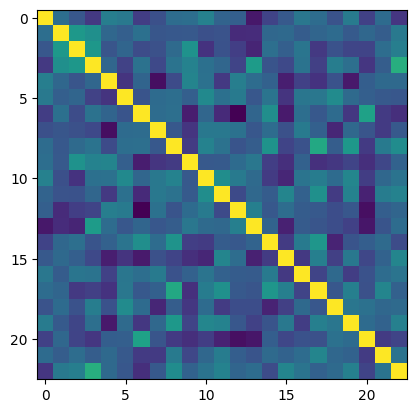

In [190]:
plt.imshow(mat.cpu())

In [191]:
amino_to_int_dict

{'C': 3,
 'D': 4,
 'S': 5,
 'Q': 6,
 'K': 7,
 'I': 8,
 'P': 9,
 'T': 10,
 'F': 11,
 'N': 12,
 'G': 13,
 'H': 14,
 'L': 15,
 'R': 16,
 'W': 17,
 'A': 18,
 'V': 19,
 'E': 20,
 'Y': 21,
 'M': 22,
 '<PAD>': 0,
 '<MASK>': 1,
 '<END>': 0}

In [192]:
# Define amino acid groups
hydrophobic = ['A', 'V', 'I', 'L', 'M', 'F', 'W', 'Y']
polar = ['S', 'T', 'N', 'Q', 'C', 'G']
acidic = ['D', 'E']
basic = ['K', 'R', 'H']
special = ['P']



# Group order by type
grouped_amino_acids = hydrophobic + polar + acidic + basic + special
grouped_amino_acids_indices = [amino_to_int_dict[aa] for aa in grouped_amino_acids if aa in amino_to_int_dict]

with torch.no_grad():

	# Reorder the embedding matrix
	reordered_embedding_matrix = hyena_model.embeddings.weight[grouped_amino_acids_indices, :]
	normalize_mat = F.normalize(reordered_embedding_matrix,dim=1)
	mat = einx.dot("n1 d,n2 d -> n1 n2",normalize_mat,normalize_mat)

In [193]:
grouped_amino_acids_indices

[18, 19, 8, 15, 22, 11, 17, 21, 5, 10, 12, 6, 3, 13, 4, 20, 7, 16, 14, 9]

In [194]:
mat.shape

torch.Size([20, 20])

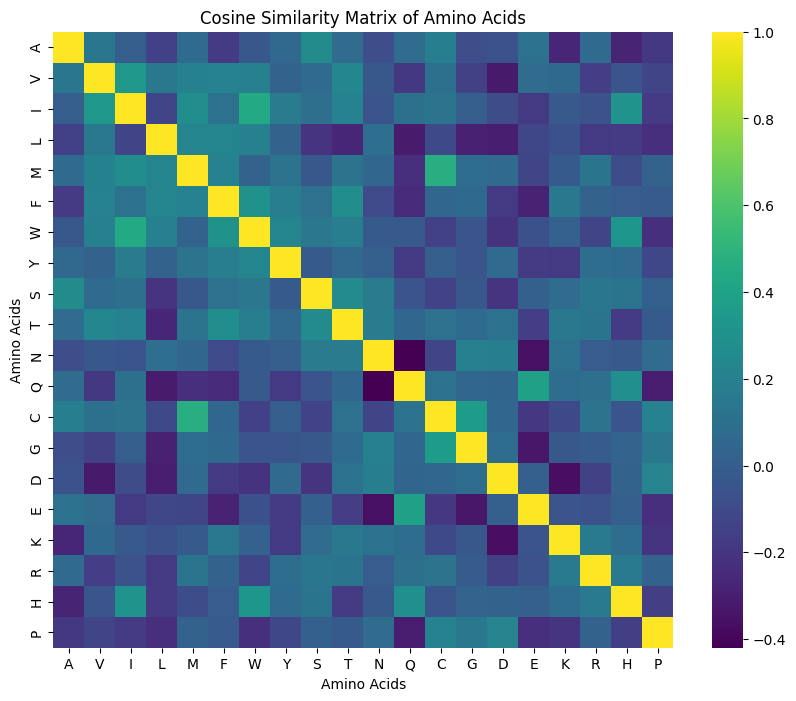

In [195]:
plt.figure(figsize=(10, 8))
sns.heatmap(mat.cpu(), xticklabels=grouped_amino_acids, yticklabels=grouped_amino_acids, cmap="viridis", annot=False)
plt.title("Cosine Similarity Matrix of Amino Acids")
plt.xlabel("Amino Acids")
plt.ylabel("Amino Acids")
plt.show()

In [196]:
grouped_amino_acids

['A',
 'V',
 'I',
 'L',
 'M',
 'F',
 'W',
 'Y',
 'S',
 'T',
 'N',
 'Q',
 'C',
 'G',
 'D',
 'E',
 'K',
 'R',
 'H',
 'P']